# Solution

### Imports

In [6]:
import time
import numpy as np
import matplotlib.pyplot as plt
from solvers import solver
from tabulate import tabulate
from scipy.interpolate import interp1d
from typing import Callable, List, Tuple, TypeVar


## Implementation

[*Write code to be able to run three methods you have chosen for arbitrary initial conditions ($x(t=0), y(t=0)$), time step ($\mathrm{d}t$), model parameters ($\alpha, \beta, \gamma, \delta$) and functions $f$ and $g$. [50 words]*]

### Model parameters

In [7]:
def rhs(t, u):
    alpha = 1
    beta = 1
    gamma = 1
    delta = 1
    f = lambda t: -np.sin(t) - np.cos(t)**2 - np.cos(t)
    g = lambda t: np.sin(t) + np.cos(t)**2 - np.cos(t)

    dx_dt = alpha * u[0] - beta * u[0] * u[1] + f(t)
    dy_dt = delta * u[0] * u[1] - gamma * u[1] + g(t)

    return np.array([dx_dt, dy_dt])

def rhs_B(t, u):
    alpha_B = 2/3
    beta_B = 4/3
    gamma_B = 1
    delta_B = 1
    f_B = lambda t: 0
    g_B = lambda t: 0

    dx_dt = alpha_B * u[0] - beta_B * u[0] * u[1] + f_B(t)
    dy_dt = delta_B * u[0] * u[1] - gamma_B * u[1] + g_B(t)

    return np.array([dx_dt, dy_dt])

### Implementing a new method

Most methods for solving systems of non-linear differential equations require not only an initial guess for $x$ and $y$, $x(t=0),  y(t=0)$, but also a second guess set for $x$ and $y$ after $dt$, $x(t=dt),  y(t=dt)$.

How can we get a good secondary guess?


In [8]:
y_type = TypeVar("y_type", np.ndarray, np.double)
def euler_method(
    rhs: Callable[[np.double, y_type], y_type],
    y0: y_type,
    t0: np.double,
    dt: np.double,
    T: np.double,
) -> Tuple[List[np.double], List[y_type]]:
    """
    Solve the differential equation using the Euler method.

    Parameters
    ----------
    rhs
        A function describing the right-hand side of the differential equation(s)
    y0
        The starting value of y
    t0
        The starting value of t
    dt
        The time step
    T
        The final or stopping time

    Returns
    -------
    t
        The time points where the solution was found
    y
        The estimate of the solution at each time point
    """
    # set initial data into solution arrays
    t_out = [t0]
    y_out = [y0]

    # count steps
    timesteps = int(T / dt)

    # time loop
    for step in range(timesteps):
        y_update = rhs(t_out[-1], y_out[-1]) * dt
        y_new = y_out[-1] + y_update
        t_new = t_out[-1] + dt

        t_out.append(t_new)
        y_out.append(y_new)

    return t_out, y_out


### Running the methods with time steps and parameters

In [29]:
# Modify run_simulation function to include euler_method
def run_simulation(u0, T, time_steps, methods, rhs_function):
    total_times = {method: [] for method in methods}
    line_positions = np.arange(len(time_steps))

    for dt_factor in time_steps:
        dt = T / dt_factor

        for method in methods:
            start_time = time.time()
            if method == "Euler":
                t, sol = euler_method(rhs_function, u0, 0, dt, T)
            elif method == "Newton":
                t, sol = newton_method(rhs_function, u0, 0, dt, T)
            else:
                t, sol = solver(rhs_function, u0, 0, dt, T, method)
            end_time = time.time()

            total_time = end_time - start_time
            total_times[method].append(total_time)

    return total_times


time_steps = [100, 200, 400, 800, 1600]
methods = ["Heun", "Runge-Kutta", "Euler"]

# Test Case A
T_A = 2.5 * np.pi
u0_A = np.array([2.0, 0.0]) # x0 = 2, y0 = 0

# Run the simulation and get total times for Test Case A
total_times_A = run_simulation(u0_A, T_A, time_steps, methods, rhs)

# Test Case B parameters
T_B = 30
u0_B = np.array([0.9, 0.9])  # x0 = 0.9, y0 = 0.9

# Run the simulation and get total times for Test Case B
total_times_B = run_simulation(u0_B, T_B, time_steps, methods, rhs_B)


## Results

[*Simulate and show results for each of the test cases suggested by your boss for a range of time steps until a final time $T$.
For test case A, you should use $T = 2.5\pi$ and (at least) $\mathrm{d}t = T/100, T/200, T/400, T/800, T/1600$.
For test case B, you should use $T = 30$ and (at least) $\mathrm{d}t = T/100, T/200, T/400, T/800, T/1600$.
You should demonstrate how solutions look for each method, and the accuracy and efficiency of each approach. [50 words]*]



### Tables of values
*Warning - large datasets below*

Tables of each value of X at each multiple of dt for the solution, for each method and step size.

In [30]:
# Display results for Test Case A
for method in methods:
    print(f"\nResults for {method} (Test Case A):\n")
    headers_A = ['Time/2.5π  (s/2.5π)', '(x)', '(y)']

    for dt_factor, times in zip(time_steps, total_times_A[method]):
        print(f"dt = T/{dt_factor}, Total Time = {times:.6f} s")

        # Convert sol_ref to a NumPy array
        if method == "Euler":
            t_ref, sol_ref = euler_method(rhs, u0_A, 0, T_A / dt_factor, T_A)
        else:
            t_ref, sol_ref = solver(rhs, u0_A, 0, T_A / dt_factor, T_A, method)
        sol_ref = np.array(sol_ref)

        # Display results in a table for Test Case A
        formatted_t = ["({}/{})".format(int(ti / (T_A / dt_factor)), int(2.5 * np.pi / (T_A / dt_factor))) for ti in t_ref]
        table_data_A = list(zip(formatted_t, sol_ref[:, 0], sol_ref[:, 1]))

        # Print the table for Test Case A
        table_A = tabulate(table_data_A, headers=headers_A, tablefmt='pretty')
        print(table_A)
        print("\n" + "=" * 50 + "\n")  # Separate tables with a line

# Display results for Test Case B
for method in methods:
    print(f"\nResults for {method} (Test Case B):\n")
    headers_B = ['Time/30  (s/30)', '(x)', '(y)']  # Adjusted headers for Test Case B

    for count, (dt_factor, times) in enumerate(zip(time_steps, total_times_B[method])):
        print(f"dt = T/{dt_factor}, Total Time = {times:.6f} s")

        # Convert sol_ref to a NumPy array
        if method == "Euler":
            t_ref, sol_ref = euler_method(rhs_B, u0_B, 0, T_B / dt_factor, T_B)
        else:
            t_ref, sol_ref = solver(rhs_B, u0_B, 0, T_B / dt_factor, T_B, method)
        sol_ref = np.array(sol_ref)

        # Display results in a table for Test Case B
        formatted_t = ["({}/{})".format(i, dt_factor) for i in range(len(t_ref))]  # Adjusted formatting for Test Case B
        table_data_B = list(zip(formatted_t, sol_ref[:, 0], sol_ref[:, 1]))

        # Print the table for Test Case B
        table_B = tabulate(table_data_B, headers=headers_B, tablefmt='pretty')
        print(table_B)
        print("\n" + "=" * 50 + "\n")  # Separate tables with a line


Results for Heun (Test Case A):

dt = T/100, Total Time = 0.005574 s
+---------------------+-----------------------+----------------------+
| Time/2.5π  (s/2.5π) |          (x)          |         (y)          |
+---------------------+-----------------------+----------------------+
|       (0/100)       |          2.0          |         0.0          |
|       (1/100)       |  1.9972817134040186   | 0.002960398638418289 |
|       (2/100)       |  1.9884663615066651   | 0.01205708617534262  |
|       (3/100)       |   1.973611730705161   | 0.027235634129529087 |
|       (4/100)       |  1.9528118517131001   | 0.048405170731133026 |
|       (5/100)       |  1.9261960619843892   | 0.07543911444969265  |
|       (6/100)       |  1.8939278483542124   | 0.10817608868670181  |
|       (7/100)       |  1.8562035115123299   |  0.146420982710053   |
|       (8/100)       |   1.813250703032639   | 0.18994612050027881  |
|       (9/100)       |  1.7653268911594713   | 0.23849249993452085  |
|      

### Calculation Time

Charts to display the efficiency of each method based on how long execution takes.

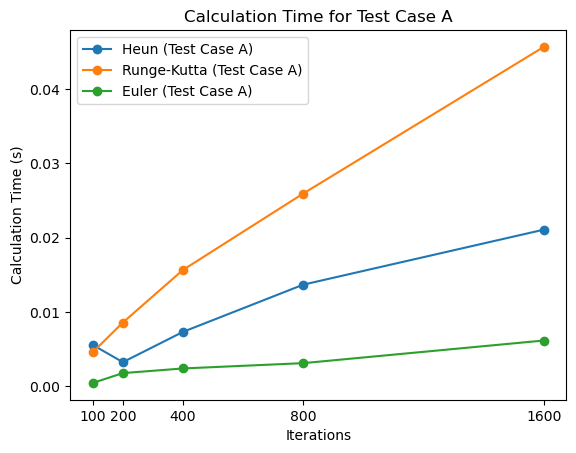

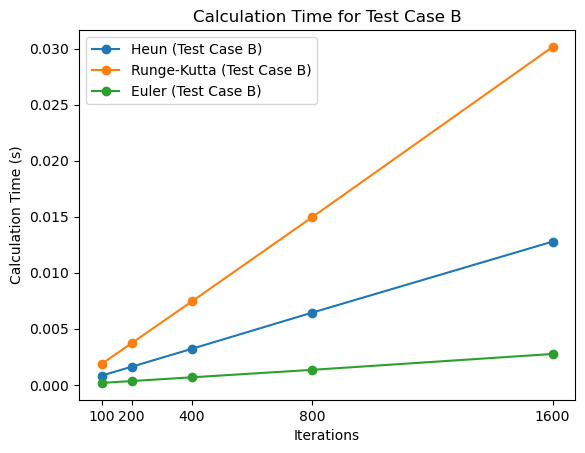

In [31]:
# Create line chart for total times for Test Case A
plt.figure()
for method in methods:
    plt.plot(time_steps, total_times_A[method], marker='o', label=f"{method} (Test Case A)")

plt.title("Calculation Time for Test Case A")
plt.xlabel("Iterations")
plt.ylabel("Calculation Time (s)")
plt.xticks(time_steps, [f'{dt_factor}' for dt_factor in time_steps])
plt.legend()
plt.show()

# Create line chart for total times for Test Case B
plt.figure()
for method in methods:
    plt.plot(time_steps, total_times_B[method], marker='o', label=f"{method} (Test Case B)")

plt.title("Calculation Time for Test Case B")
plt.xlabel("Iterations")
plt.ylabel("Calculation Time (s)")
plt.xticks(time_steps, [f'{dt_factor}' for dt_factor in time_steps])
plt.legend()
plt.show()


### Visualisations of the solutions
Solution tables for x and y at each point in time, using the smallest step size.

All methods are shown, although almost entirely overlap as difference in accuracy is negligible.

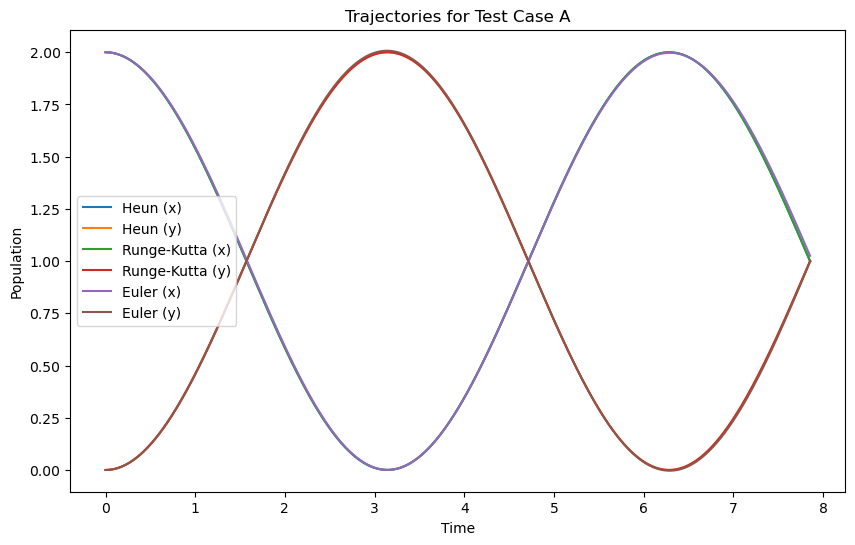

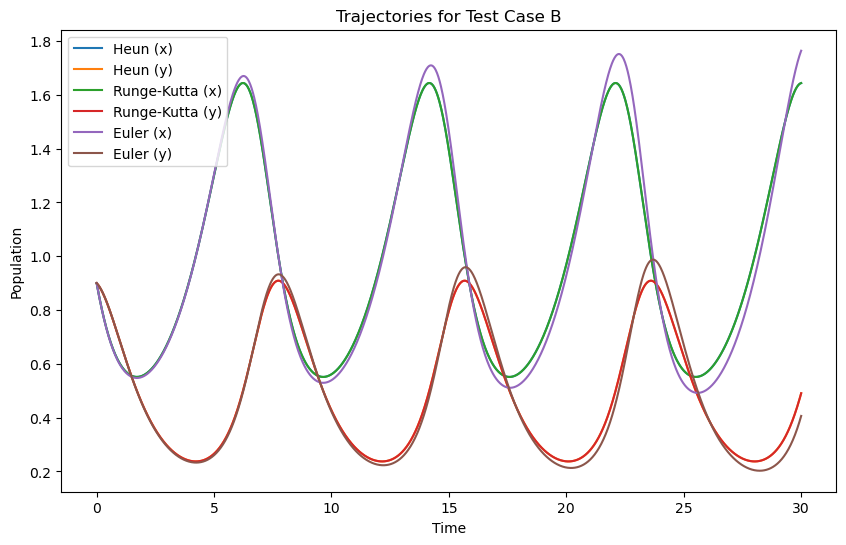

In [32]:
# Plotting trajectories for Test Case A
plt.figure(figsize=(10, 6))
for method in methods:
    if method == "Euler":
        t, sol = euler_method(rhs, u0_A, 0, T_A / 1600, T_A)
    else:
        t, sol = solver(rhs, u0_A, 0, T_A / 1600, T_A, method)
    sol = np.array(sol)
    plt.plot(t, sol[:, 0], label=f"{method} (x)")
    plt.plot(t, sol[:, 1], label=f"{method} (y)")

plt.title("Trajectories for Test Case A")
plt.xlabel("Time")
plt.ylabel("Population")
plt.legend()
plt.show()

# Plotting trajectories for Test Case B
plt.figure(figsize=(10, 6))
for method in methods:
    if method == "Euler":
        t, sol = euler_method(rhs_B, u0_B, 0, T_B / 1600, T_B)
    else:
        t, sol = solver(rhs_B, u0_B, 0, T_B / 1600, T_B, method)
    sol = np.array(sol)
    plt.plot(t, sol[:, 0], label=f"{method} (x)")
    plt.plot(t, sol[:, 1], label=f"{method} (y)")

plt.title("Trajectories for Test Case B")
plt.xlabel("Time")
plt.ylabel("Population")
plt.legend()
plt.show()

### Solution inaccuracy
We can compare test case A to its exact solution to find out the accuracy of each method.

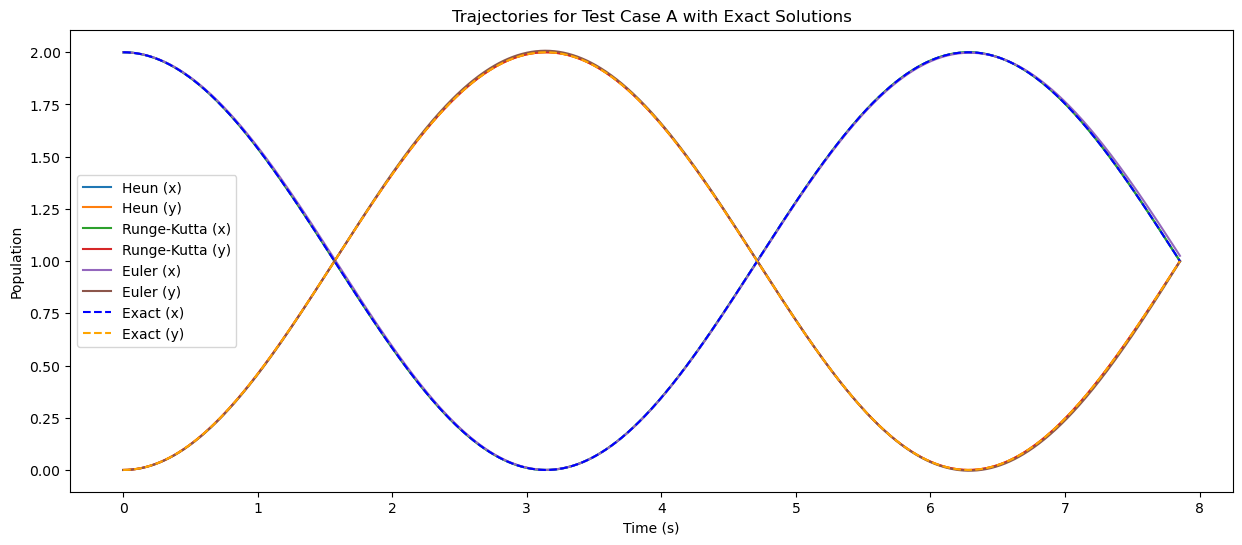

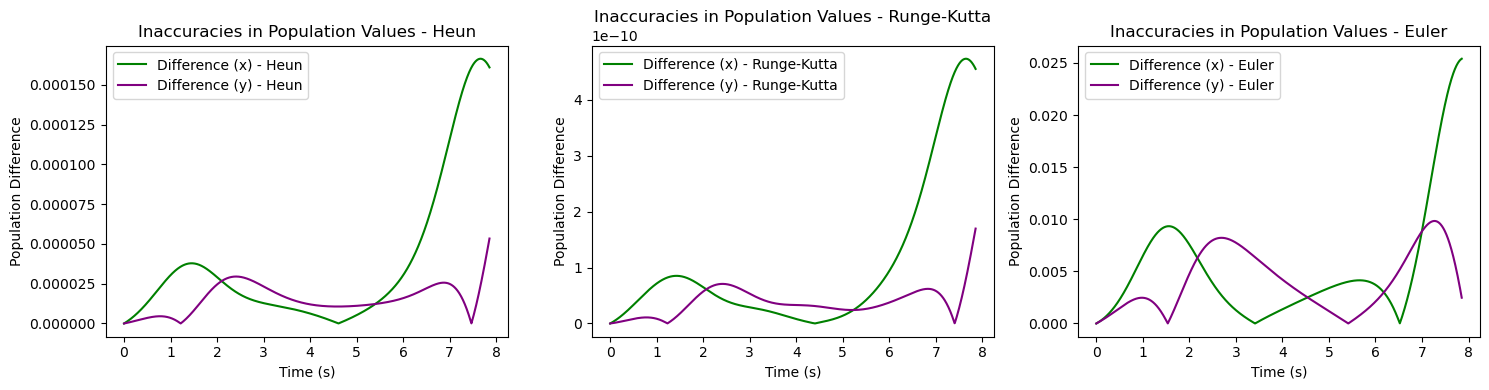

In [58]:
import numpy as np
import matplotlib.pyplot as plt

# ... (Your existing code)

# Graphs for Test Case A with Exact Solutions and Differences
plt.figure(figsize=(15, 6))

# Create subplot for the graph of trajectories
for method in methods:
    if method == "Euler":
        t, sol = euler_method(rhs, u0_A, 0, T_A / 1600, T_A)
    else:
        t, sol = solver(rhs, u0_A, 0, T_A / 1600, T_A, method)
    sol = np.array(sol)
    plt.plot(t, sol[:, 0], label=f"{method} (x)")
    plt.plot(t, sol[:, 1], label=f"{method} (y)")

# Plotting the exact solutions for Test Case A with different colors
t_exact_A = np.linspace(0, T_A, num=len(t))  # Use the same length as t
x_exact_A = 1 + np.cos(t_exact_A)
y_exact_A = 1 - np.cos(t_exact_A)
plt.plot(t_exact_A, x_exact_A, label="Exact (x)", linestyle="--", color='blue')
plt.plot(t_exact_A, y_exact_A, label="Exact (y)", linestyle="--", color='orange')

plt.title("Trajectories for Test Case A with Exact Solutions")
plt.xlabel("Time (s)")
plt.ylabel("Population")
plt.legend()

# Create separate graphs for each method
plt.figure(figsize=(15, 4))

for idx, method in enumerate(methods, 1):
    plt.subplot(1, 3, idx)

    if method == "Euler":
        t, sol = euler_method(rhs, u0_A, 0, T_A / 1600, T_A)
    else:
        t, sol = solver(rhs, u0_A, 0, T_A / 1600, T_A, method)
    sol = np.array(sol)

    # Calculate differences between exact and method solutions for both x and y
    diff_A_x = abs(x_exact_A - sol[:, 0])
    diff_A_y = abs(y_exact_A - sol[:, 1])

    # Plot the differences on the same graph
    plt.plot(t, diff_A_x, label=f"Difference (x) - {method}", color='green')
    plt.plot(t, diff_A_y, label=f"Difference (y) - {method}", color='purple')

    plt.title(f"Inaccuracies in Population Values - {method}")
    plt.xlabel("Time (s)")
    plt.ylabel("Population Difference")
    plt.legend()

plt.tight_layout()  # Adjust layout for better spacing

plt.show()


We can see that the inaccuracies of $x$ and $y$ begin to spike as we reach the end of our $T$ value.

## Analysis

[*Comment on the efficiency and accuracy of each approach. [250 words]*]

## Conclusion

[*Compare the methods that you have results for, and any other relevant methods from the module, and make a recommendation of which method you think is best. [300 words]*]